# Regression modeling using Random Forest, XGBoost

### **Imports**

In [ ]:
    %matplotlib inline
!pip install category_encoders
from google.colab import drive
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/AML")
pd.set_option('display.max_rows', 20)
#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from category_encoders import TargetEncoder
import xgboost
from sklearn.externals import joblib
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")

     |████████████████████████████████| 102kB 2.5MB/s 


# **Task 1**

In [ ]:
#Data preparation
#load data and explore data
data = pd.read_csv('vehicles.csv')
#fill in the the missing rows for description
#extract two features: length of the description and wheather the word new is present or not
data.description.fillna(0, inplace=True)
data['description'] = data['description'].str.lower()
data['New'] = 0
data['New'] = np.where(data['description'].str.contains('new'), data['New'], 1)
data['description'] = data['description'].str.len()
print(data.describe(include='all'))
#remove features that are not important
#county: all NaN
#vin: does not seem to be adding any value
#id: should be unique and not a logical feature
#image_url: all are more of less of same length
data.drop(columns=['id', 'url', 'vin', 'region_url', 'image_url', 'county'], inplace=True)
#price: only keep rows with price > 0 assuming rest are missing prices for training
data = data[data['price'] > 0]

                  id  ...            New
count   5.095770e+05  ...  509577.000000
unique           NaN  ...            NaN
top              NaN  ...            NaN
freq             NaN  ...            NaN
mean    7.044176e+09  ...       0.567316
std     4.937219e+06  ...       0.495448
min     6.995212e+09  ...       0.000000
25%     7.040802e+09  ...       0.000000
50%     7.045325e+09  ...       1.000000
75%     7.048556e+09  ...       1.000000
max     7.050103e+09  ...       1.000000

[11 rows x 26 columns]


### Checking the distribution of prices (output)

Shape of the sample data  (462348, 20)


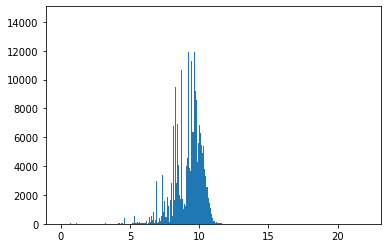

In [ ]:
#check the distribution of prices
#take log as prices are highly skewed
_ = plt.hist(np.log(data['price']), bins="auto")
#outliers: it seems log(prices) greater than 13 or less than 4 can be excluded for training
sample_data = data[(np.log(data['price']) < 13) & (np.log(data['price']) > 4)]
#after excluding the extreme values the dataset still contains more than 90%
print('Shape of the sample data ', sample_data.shape)

We notice a slight left skew in the output variable, so we could use a log transform for the variable while training.

In [ ]:
sample_data.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'description', 'state', 'lat',
       'long', 'New'],
      dtype='object')

Subsampling:

In [ ]:
#Subsampling: 40,000 sample seems to be a good starting point for training and validation
#because there are many features
train_test_data = sample_data.sample(n=40000)
print(train_test_data.columns)
print(train_test_data.describe(include='all'))

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'description', 'state', 'lat',
       'long', 'New'],
      dtype='object')
             region          price  ...          long           New
count         40000   40000.000000  ...  39538.000000  40000.000000
unique          399            NaN  ...           NaN           NaN
top     springfield            NaN  ...           NaN           NaN
freq            328            NaN  ...           NaN           NaN
mean            NaN   13875.472275  ...    -94.202302      0.568025
std             NaN   11893.714091  ...     17.737324      0.495357
min             NaN      59.000000  ...   -165.935000      0.000000
25%             NaN    5409.250000  ...   -106.708500      0.000000
50%             NaN   10898.000000  ...    -88.294500      1.000000
75%             NaN   18995.000000  ...    -81.106300

In [ ]:
train_test_data.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'description', 'state', 'lat',
       'long', 'New'],
      dtype='object')

Visualizing distributions of continuous variable:

In [ ]:
#check the distribution of all the continuous variables
cols = list(train_test_data._get_numeric_data().columns)
fig = plt.figure(figsize=(12,6))
for i, col in enumerate(cols, 1):
  plt.subplot(3,2,i)
  plt.hist(train_test_data[col], bins = 'auto')
  plt.title(str(col))
plt.tight_layout()

#Task 2

Train Test Split:

In [ ]:
y = train_test_data['price']
#Drop price
train_test_data.drop(['price'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_test_data, y)

Checking the relationship between target variable and features:

ValueError: ignored

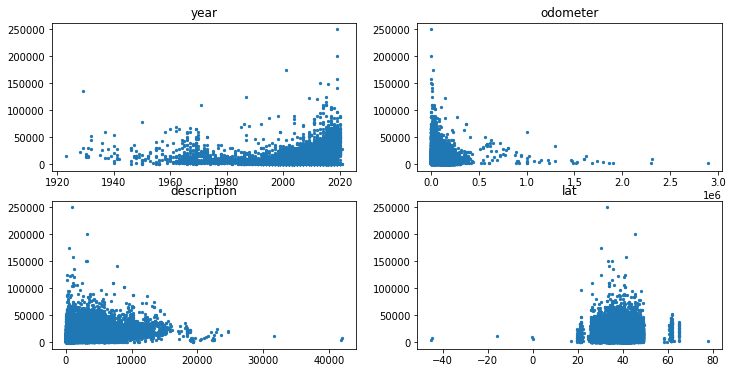

In [ ]:
#check the relation between output and continuous features
cols = list(X_train._get_numeric_data().columns)
fig = plt.figure(figsize=(12,6))
for i, col in enumerate(cols, 1):
  plt.subplot(2,2,i)
  plt.scatter(X_train[col], y_train, s=5)
  plt.title(str(col))
plt.tight_layout()

Creating pipelines for baseline models

In [ ]:
#make pipeline for preprocessing continuous and categorical features
#do necessary pre-processing for continuous and categorical variables
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))
cont_preprocessing = make_pipeline(
    SimpleImputer(strategy='most_frequent'), 
    #PolynomialFeatures(), #Try polynomial features (performed bad)
    #VarianceThreshold(),  #Checked but did not change any results
    StandardScaler())
preprocess = make_column_transformer( 
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing)
te = TargetEncoder(cols=['region']) #tried on model but performance was not good, also region does not improve the R2

#since the output is skewed use log regressor
#Linear Regression
log_regressor = TransformedTargetRegressor(
    LinearRegression(), func=np.log, inverse_func=np.exp)
pipe_regressor = Pipeline([('preprocess', preprocess), ('model', log_regressor)])

#Ridge Regression
log_ridge = TransformedTargetRegressor(
    Ridge(), func=np.log, inverse_func=np.exp)
pipe_ridge = Pipeline([('preprocess', preprocess), ('model', log_ridge)])

#Lasso
log_lasso = TransformedTargetRegressor(
    Lasso(), func=np.log, inverse_func=np.exp)
pipe_lasso = Pipeline([('preprocess', preprocess), ('model', log_lasso)])

#Elasticnet
log_elasticnet = TransformedTargetRegressor(
    ElasticNet(), func=np.log, inverse_func=np.exp)
pipe_elasticnet = Pipeline([('preprocess', preprocess), ('model', log_elasticnet)])

kf = KFold(n_splits=5)

In [ ]:
scores_regressor = cross_val_score(pipe_regressor, X_train, y_train, cv=kf)
print('Linear regression cross validation validation score ', round(np.mean(scores_regressor),4))
print('==============================')

scores_ridge = cross_val_score(pipe_ridge, X_train, y_train, cv=kf)
print('Ridge regression cross validation validation score ', round(np.mean(scores_ridge),4))
print('==============================')

scores_lasso = cross_val_score(pipe_lasso, X_train, y_train, cv=kf)
print('Lasso cross validation validation score ', round(np.mean(scores_lasso),4))
print('==============================')

scores_elasticnet = cross_val_score(pipe_elasticnet, X_train, y_train, cv=kf)
print('Elasticnet cross validation validation score ', round(np.mean(scores_elasticnet),4))
print('==============================')

Linear regression cross validation validation score  -7.8354
Ridge regression cross validation validation score  0.5108
Lasso cross validation validation score  -0.1351
Elasticnet cross validation validation score  -0.1351


Improving Ridge by Grid Search:

In [ ]:
#Ridge regression seems to be performing the best
#do grid search over Ridge Regression alpha
param_grid = {'model__regressor__alpha': np.logspace(-3, 3, 10)}
grid = GridSearchCV(pipe_ridge, param_grid=param_grid, cv=kf, return_train_score=True)
grid.fit(X_train, y_train)

print(f"best mean cross-validation score: {round(grid.best_score_,4)}")
print(f"best parameters: {grid.best_params_}")
print(f"test-set score: {grid.score(X_test, y_test)}")

best mean cross-validation score: 0.5153
best parameters: {'model__regressor__alpha': 0.46415888336127775}
test-set score: 0.4633253944091954


Our baseline model is ridge regression model whose paramters were found using grid search. As we can see that the score on test set is not really good so we will try to improve this with ensemble based methods.

#Task 3

## Random Forest:

In [ ]:
#Random forest regressor
preprocess = make_column_transformer( 
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')), 
                                                                  make_column_selector(dtype_include='object')),
                                     remainder=SimpleImputer(strategy='most_frequent'))
rf_regressor = RandomForestRegressor(n_estimators=500, max_depth=10)
pipe_rf = Pipeline([('preprocess', preprocess), ('model', rf_regressor)])


scores_rf = cross_val_score(pipe_rf, X_train, y_train, cv=kf)

print('RF regression cross validation validation score ', round(np.mean(scores_rf),4))

RF regression cross validation validation score  0.6274


In [ ]:
#Random forest experiments
#look for optimum n_estimator and depth
n_estimator = [500]
max_depth = [10]

train_scores, test_scores = [], []

preprocess = make_column_transformer( 
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')), 
                                                                  make_column_selector(dtype_include='object')),
                                     remainder=make_pipeline(SimpleImputer(strategy='most_frequent'),PolynomialFeatures()))
pre = preprocess.fit(X_train, y_train)
X_train_ = pre.transform(X_train)

#n_estimators do not improve
for n in n_estimator:
  for d in max_depth:
    start = time.time()
    print(f'n {n} and d {d}')
    
    rf_regressor = RandomForestRegressor(n_estimators=n, max_depth=d, max_features=0.2, warm_start=True)
    rf_regressor.fit(X_train_, y_train)

    train_scores.append((n, d, rf_regressor.score(X_train_, y_train)))
    test_scores.append((n, d, rf_regressor.score(pre.transform(X_test), y_test)))
    print(f'Score for training set {rf_regressor.score(X_train_, y_train)}')
    print(f'Score for testing set {rf_regressor.score(pre.transform(X_test), y_test)}')
    print(f'Total time taken {(time.time() - start)} s')
    print('==============================')

n 500 and d 10
Score for training set 0.7830227874468637
Score for training set 0.5819929752506104
Total time taken 94.20857191085815 s
------------------------------


Random forest with polynomial features and imputation methods provides us a better test score than the baseline models.

# Task 4 

# Gradient Boosting (sklearn):

In [ ]:
#sklearn Gradient Boosting regressor
gbm_regressor = GradientBoostingRegressor(max_depth=10, n_estimators=500)
pipe_gbm = Pipeline([('preprocess', preprocess), ('model', gbm_regressor)])
scores_gbm = cross_val_score(pipe_gbm, X_train, y_train, cv=kf)

print('GB regression cross validation validation score ', round(np.mean(scores_gbm),4))

GB regression cross validation validation score  0.6147


In [ ]:
#sklearn gradient boosting experiments
#look for optimum n_estimator and depth
n_estimator = [500]
max_depth = [10]
train_scores, test_scores = [], []

preprocess = make_column_transformer( 
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')), 
                                                                  make_column_selector(dtype_include='object')),
                                     remainder=make_pipeline(SimpleImputer(strategy='most_frequent'), PolynomialFeatures()))
pre = preprocess.fit(X_train, y_train)
X_train_ = pre.transform(X_train)


for n in n_estimator:
  for d in max_depth:
    start = time.time()
    print(f'n {n} and d {d}')
    
    gbm_regressor = GradientBoostingRegressor(max_depth=d, n_estimators=n, max_features=0.2)
    gbm_regressor.fit(X_train_, y_train)

    train_scores.append((n, d, gbm_regressor.score(X_train_, y_train)))
    test_scores.append((n, d, gbm_regressor.score(pre.transform(X_test), y_test)))
    print(f'Score for training set {gbm_regressor.score(X_train_, y_train)}')
    print(f'Score for testing set {gbm_regressor.score(pre.transform(X_test), y_test)}')
    print(f'Total time taken {(time.time() - start)} s')
    print('==============================')

n 500 and d 10
Score for training set 0.9644722325599917
Score for training set 0.6727950741006012
Total time taken 55.43500304222107 s
------------------------------


## XGBoost (Faster):

In [ ]:
#extreme gradient boosting (faster than sklearn gbm) experiements
#look for optimum n_estimator and depth
n_estimator = [500]
max_depth = [10]
train_scores = []
test_scores = []

preprocess = make_column_transformer( 
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')), 
                                                                  make_column_selector(dtype_include='object')),
                                     remainder=make_pipeline(SimpleImputer(strategy='most_frequent'), PolynomialFeatures()))
pre = preprocess.fit(X_train, y_train)
X_train_ = pre.transform(X_train)
for n in n_estimator:
  for d in max_depth:
    start = time.time()
    print(f'n {n} and d {d}')
    #colsample does not affect the rmse much, alpha does not help
    xg_regressor = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.2, learning_rate=0.1,
                    max_depth=d, alpha=0, n_estimators = n, reg_lambda=1)
    xg_regressor.fit(X_train_, y_train)
    train_scores.append((n, d, xg_regressor.score(X_train_, y_train)))
    test_scores.append((n, d, xg_regressor.score(pre.transform(X_test), y_test)))
    print(f'Score for training set {xg_regressor.score(X_train_, y_train)}')
    print(f'Score for testing set {xg_regressor.score(pre.transform(X_test), y_test)}')
    print(f'Total time taken {(time.time() - start)} s')
    print('==============================')

n 500 and d 10
Score for training set 0.9354223948972621
Score for testing set 0.7220669034159392
Total time taken 31.152083158493042 s


In [ ]:
kf = KFold(n_splits=5)
xg_regressor = xgboost.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.2, learning_rate=0.1,
                    max_depth=10, alpha=0, n_estimators = 500, reg_lambda=1)
pipe_xgr = Pipeline([('preprocess', preprocess), ('model', xg_regressor)])
scores_xgr = cross_val_score(pipe_xgr, X_train, y_train, cv=kf)
print('XGBoost regression cross validation validation score ', round(np.mean(scores_xgr),4))

XGBoost regression cross validation validation score  0.7365


We find that the xgboost model provides much better performance than the other models. It also has a better runtime and can handle missing values as well. 

In [ ]:
features = grid.best_estimator_.named_steps['model'].feature_importances__
features_ind = [(i, val) for i, val in enumerate(features, 1)]
features_ind.sort(key=lambda x: x[1], reverse=True)

AttributeError: ignored

In [ ]:
target_columns=["manufacturer", "model", "region"]
cat_columns=["paint_color", "type", "drive", "transmission", "title_status", "fuel", "cylinders"]
cont_columns=["odometer"]


preprocess = make_column_transformer( 
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')), 
                                                                  make_column_selector(dtype_include='object')),
                                     remainder=SimpleImputer(strategy='most_frequent'))

preprocessor_scaled=make_column_transformer((make_pipeline(SimpleImputer(strategy='median'),StandardScaler()), cont_columns), (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')),cat_columns), (make_pipeline(SimpleImputer(strategy='most_frequent'),TargetEncoder()), target_columns), remainder='passthrough')
random_pipe=make_pipeline(preprocessor_scaled, RandomForestRegressor(max_depth=5))

random_pipe.fit(X_train,y_train)
random_res=random_pipe.predict(X_test)

print(random_pipe.score(X_test,y_test))


In [ ]:
# preprocessor_scaled.transformers

In [ ]:
# random forest features
preprocess = make_column_transformer( 
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='NA'),OneHotEncoder(handle_unknown='ignore')), 
                                                                  make_column_selector(dtype_include='object')),
                                     remainder=SimpleImputer(strategy='most_frequent'))
rf_regressor = RandomForestRegressor(n_estimators=500, max_depth=10)
pipe_rf = Pipeline([('preprocess', preprocess), ('model', rf_regressor)])

pipe=Pipeline([('imputer', preprocess), ('model', RandomForestRegressor())])
param_grid = {'model__max_depth':[1,3,5,7],'model__n_estimators':[100,200]}
random_grid = GridSearchCV(pipe, param_grid)

random_grid.fit(X_train, y_train)
y_pred_train=random_grid.predict(X_train)
y_pred_test=random_grid.predict(X_test)







#Task 5 

Finding out the categorical and continuous features in the dataset

In [ ]:

cat_features=[]
cont_features=[]
for i in range (0,X_train.shape[1]):
    if X_train.dtypes[i] == 'object':
        cat_features.append(X_train.columns[i])
    else:
        cont_features.append(X_train.columns[i])




Defining pipelines for continuous, one hot and target encoded features

In [ ]:

numeric_transformer_us = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
target_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())])

In [ ]:


preprocessor_us = ColumnTransformer(transformers=[
        ('num', numeric_transformer_us, cont_features),
        ('cat', categorical_transformer, cat_features)])

        # ('target', target_transformer, target_features)])

Performing grid search for random forest parameters, we are limiting the no of estimators to 300, as model training time was increasing a lot after that.

In [ ]:
pipe=Pipeline([('imputer', preprocessor_us), ('model', RandomForestRegressor())])
param_grid = {'model__max_depth':[1,3,5,7],'model__n_estimators':[100,200,300]}
random_grid = GridSearchCV(pipe, param_grid)

random_grid.fit(X_train, y_train)
y_pred_train=random_grid.predict(X_train)
y_pred_test=random_grid.predict(X_test)

In [ ]:
print(random_grid.best_params_)

{'model__max_depth': 7, 'model__n_estimators': 300}


In [ ]:
pipe_r=make_pipeline(preprocessor_us, RandomForestRegressor(max_depth=7, n_estimators=300))
pipe_r.fit(X_train, y_train)




Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                          

In [ ]:
pipe_r.score(X_test,y_test)

0.5719114964458956

We shall now find the feature importances of the variable for the predictions. This will help us select a subset of features. 

In [ ]:
# names = list(np.hstack([preprocessor.named_transformers_['cat']['onehot'].get_feature_names(), pd.Index(cat_features)]))
tot_features=cont_features
oh_features=preprocessor_us.named_transformers_['cat']['onehot'].get_feature_names()
tot_features.extend(oh_features)

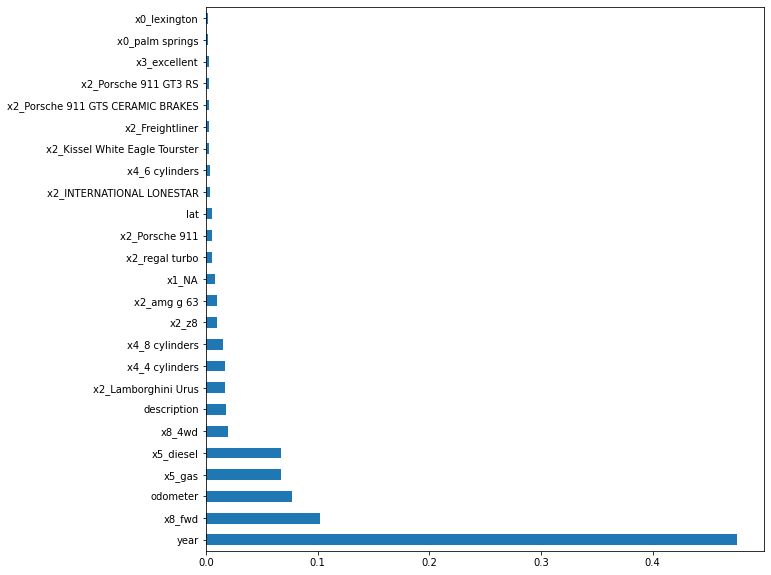

In [ ]:
# len(pipe_r[1].feature_importances_)
# tot_features
imp=pd.Series(pipe_r[1].feature_importances_, tot_features)
imp.nlargest(25).plot(kind='barh', figsize=(10,10))

We notice that the features related to year, odometer, fuel, model are important features.

In [ ]:
pipe = Pipeline([('processor', preprocessor_us),('model',xgboost.XGBRegressor(booster='gbtree',n_jobs=8, objective='reg:squarederror'))])
param_grid= {'model__max_depth':[1,3,5,7],'model__n_estimators':[100,200,300]}
boost_grid = GridSearchCV(pipe, param_grid)
boost_grid.fit(X_train, y_train)


ERROR! Session/line number was not unique in database. History logging moved to new session 63


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('processor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [ ]:
print(boost_grid.best_params_)

{'model__max_depth': 7, 'model__n_estimators': 300}


In [ ]:
pipe_b=make_pipeline(preprocessor_us, xgboost.XGBRegressor(booster='gbtree',n_jobs=8, objective='reg:squarederror', max_depth=7, n_estimators=300))
pipe_b.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                          

In [ ]:
pipe_b.score(X_test,y_test)

0.7060485353403259

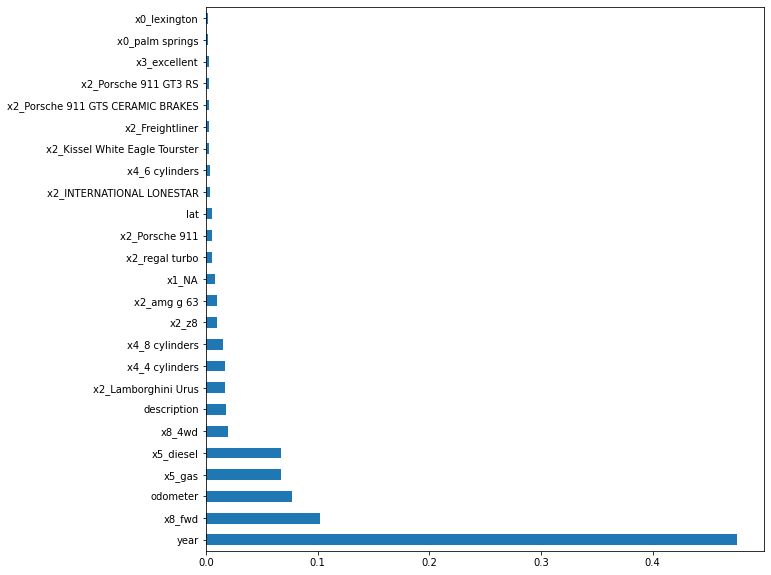

In [ ]:
tot_features=cont_features
oh_features=preprocessor_us.named_transformers_['cat']['onehot'].get_feature_names()
tot_features.extend(oh_features)

imp=pd.Series(pipe_r[1].feature_importances_, tot_features)
imp.nlargest(25).plot(kind='barh', figsize=(10,10))

From here also, we see that year, model, fuel and some region features are important.

## Task 6
For the explainable model we take the following features based on the feature importances in xgboost and random forest - year, model, odometer, region, fuel

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(train_test_data, y)

imp_features=["year", "model", "odometer", "region", "fuel"]

simple_data=train_test_data[imp_features]
simple_data.head()

,year,model,odometer,region,fuel
29837,2013.0,tahoe 1500 ltz 4x4 gas,132381.0,wenatchee,gas
146875,2018.0,discovery,17561.0,hartford,gas
452442,2001.0,highlander sport,195000.0,rhode island,gas
359369,2010.0,flex,NaN,south jersey,gas
465262,2016.0,tahoe,51000.0,chattanooga,gas


We do imputation of the missing values in the new sample dataset of 5 features.
We imopute continuous variables with median and target encoded variables with a new label.

In [ ]:
simple_data['odometer'].fillna(simple_data.odometer.median(), inplace=True)
simple_data['year'].fillna(simple_data.year.median(), inplace=True)
simple_data['model'].fillna('NA', inplace=True)
simple_data['region'].fillna(simple_data.region.mode(), inplace=True)
simple_data['fuel'].fillna('NB', inplace=True)

In [ ]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(simple_data, y, test_size=0.25)

In [ ]:
X_train_n.head()

,year,model,odometer,region,fuel
287269,2017.0,tundra,36696.0,kalamazoo,gas
146145,2007.0,TOYOTA** COROLLA**,118445.0,hartford,gas
324250,2008.0,isuzu npr hd,299000.0,asheville,diesel
468457,1998.0,dakota,115200.0,knoxville,gas
438956,2012.0,enclave leather group,256220.0,lancaster,gas


We have divided our 5 variables into these three categories.

In [ ]:
cat_features_n=["fuel"]
target_features_n=["model","region"]
cont_features_n=["odometer","year"]

In [ ]:
numeric_transformer_us = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
target_transformer = Pipeline(steps=[
    ('target', TargetEncoder()), ('scaler', StandardScaler
                                  ())])


In [ ]:
preprocessor_us = ColumnTransformer(transformers=[
        ('num', numeric_transformer_us, cont_features_n),
        ('cat', categorical_transformer, cat_features_n),

        ('target', target_transformer, target_features_n)])

In [ ]:
pipe_lr=make_pipeline(preprocessor_us, LinearRegression())
pipe_lr.fit(X_train_n, y_train_n)
y_pred=pipe_lr.predict(X_test_n)
print(pipe_lr.score(X_test_n,y_test_n))


0.43508060938574655


WIth this simple linear regression model, we get a R2 score which is not as good as the xgboost models we tried earlier.

In [ ]:
cat_f=preprocessor_us.named_transformers_['cat']['onehot'].get_feature_names()
# target_f=preprocessor_us.named_transformers_['target']['onehot'].get_feature_names()

tot_features_n=cont_features_n+list(cat_f)+target_features_n

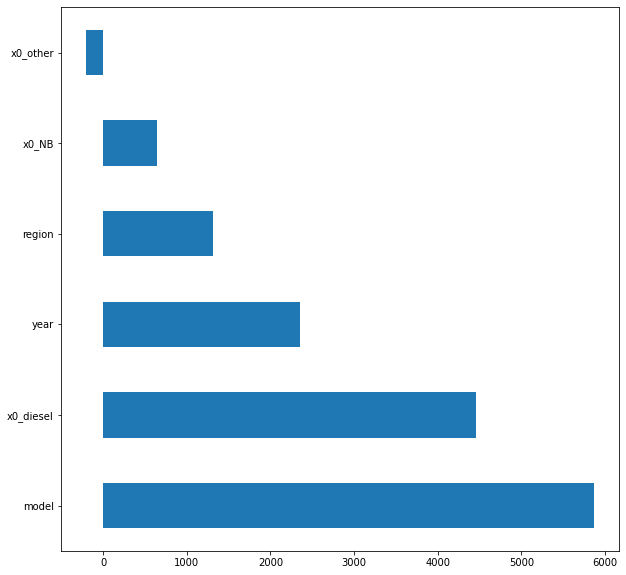

In [ ]:
imp=pd.Series(pipe_lr[1].coef_, tot_features_n)
imp.nlargest(6).plot(kind='barh', figsize=(10,10))

We plot the feature coefficients of the variables of linear regression , model, fuel and year seem to dominate.

In [ ]:
pipe_dt=make_pipeline(preprocessor_us, DecisionTreeRegressor(max_depth=7))
pipe_dt.fit(X_train_n, y_train_n)
y_pred=pipe_dt.predict(X_test_n)
print(pipe_dt.score(X_test_n,y_test_n))

0.5900810823441056


The decision tree regressor performs a bit better than the linear regression, but the decision tree will tend to overfit to the training data, so it may not generalize very well.

In [ ]:
cat_f=preprocessor_us.named_transformers_['cat']['onehot'].get_feature_names()
# target_f=preprocessor_us.named_transformers_['target']['onehot'].get_feature_names()

tot_features_n=cont_features_n+list(cat_f)+target_features_n

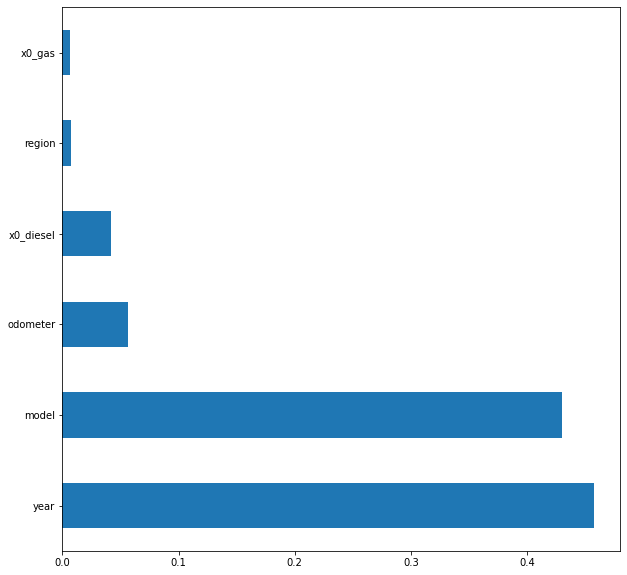

In [ ]:
imp=pd.Series(pipe_dt[1].feature_importances_, tot_features_n)
imp.nlargest(6).plot(kind='barh', figsize=(10,10))

Here also, we find that the year and model of the car are the most important features

In [ ]:
new_df=preprocessor_us.fit_transform(X_train_n, y_train_n)

In [ ]:
new_df=pd.DataFrame(new_df, columns=tot_features_n)

In [ ]:
new_df.head()

,odometer,year,x0_NB,x0_diesel,x0_electric,x0_gas,x0_hybrid,x0_other,model,region
0,-0.881349,0.886944,0.0,0.0,0.0,1.0,0.0,0.0,0.626784,0.055831
1,0.216996,-0.283780,0.0,0.0,0.0,1.0,0.0,0.0,-1.100276,-0.705892
2,2.642856,-0.166707,0.0,1.0,0.0,0.0,0.0,0.0,0.233871,0.041752
3,0.173397,-1.337431,0.0,0.0,0.0,1.0,0.0,0.0,-1.250899,-0.441284
4,2.068082,0.301582,0.0,0.0,0.0,1.0,0.0,0.0,0.038619,-0.364208


In [ ]:

pipe_dt2=DecisionTreeRegressor(max_leaf_nodes=9)
pipe_dt2=pipe_dt2.fit(new_df, y_train_n)

In [ ]:
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image
import graphviz

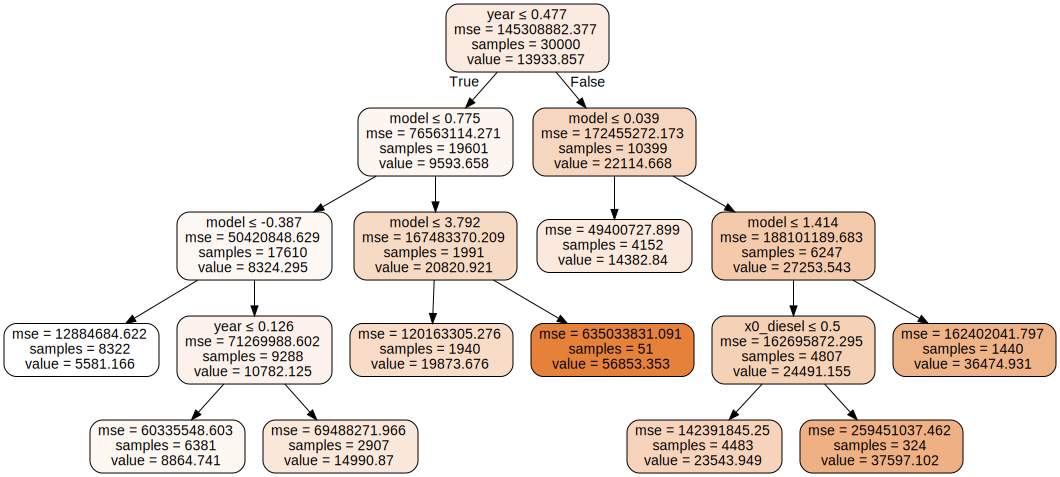

In [ ]:
dt2=tree.export_graphviz(pipe_dt2, out_file=None, feature_names=tot_features_n, filled=True,
                         rounded=True, special_characters=True)
my_plot=graphviz.Source(dt2)
my_plot

#Conclusion
For this dataset,we had to start by checking the distributions of the input features, this helped us remove some of the redundant variables. Then we had to perform missing value analysis of the columns and decide different ways to impute the missing values for continuous and categorical variables. 
We then try out various models and tune their hyper parameters using grid search. We select a smaller set of features using the feature importances and run the models again with the smaller subset. 

My main takeaway points for this assignment were the feature selection and the missing data analysis.